In [3]:
##### Step 1: Import necessary modules
##### =================================
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


[*********************100%***********************]  8 of 8 completed


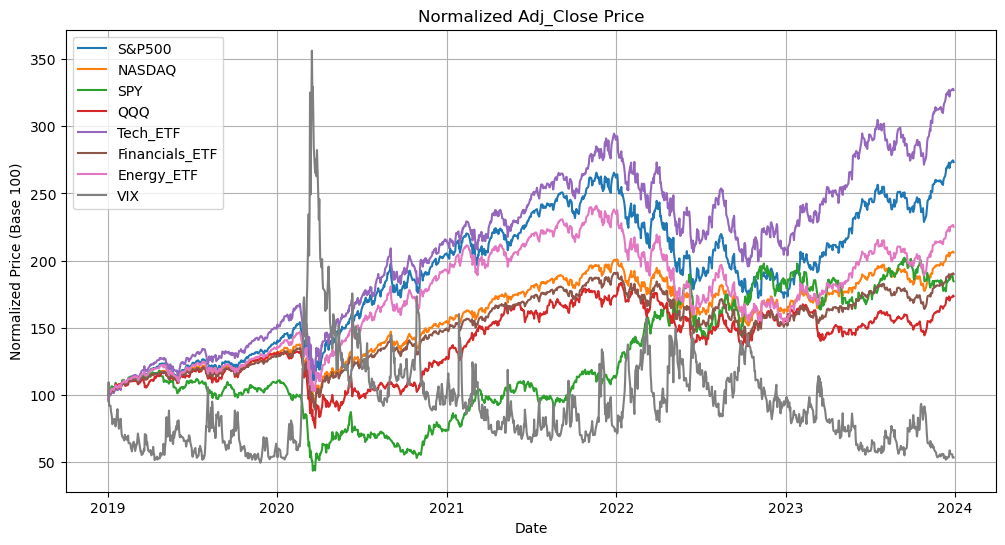

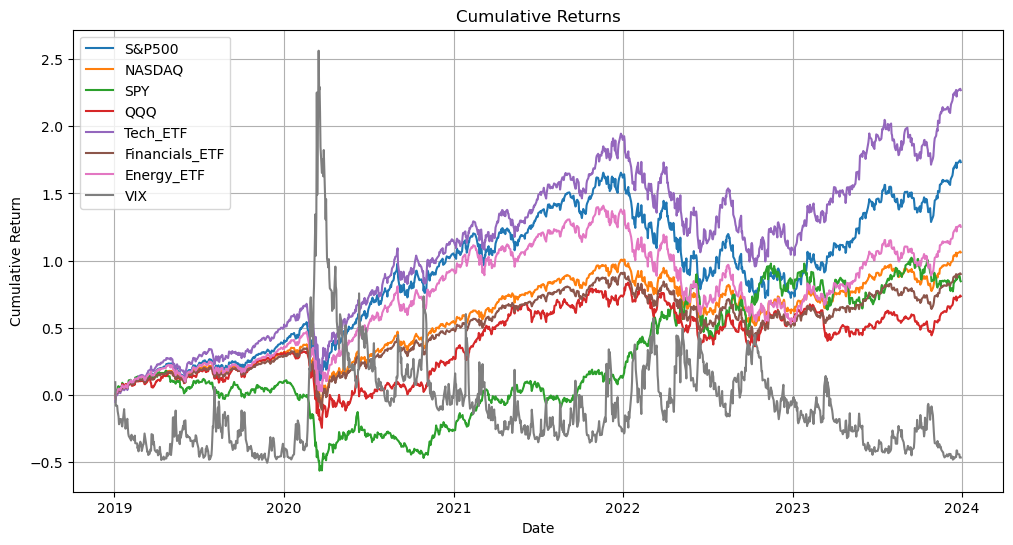

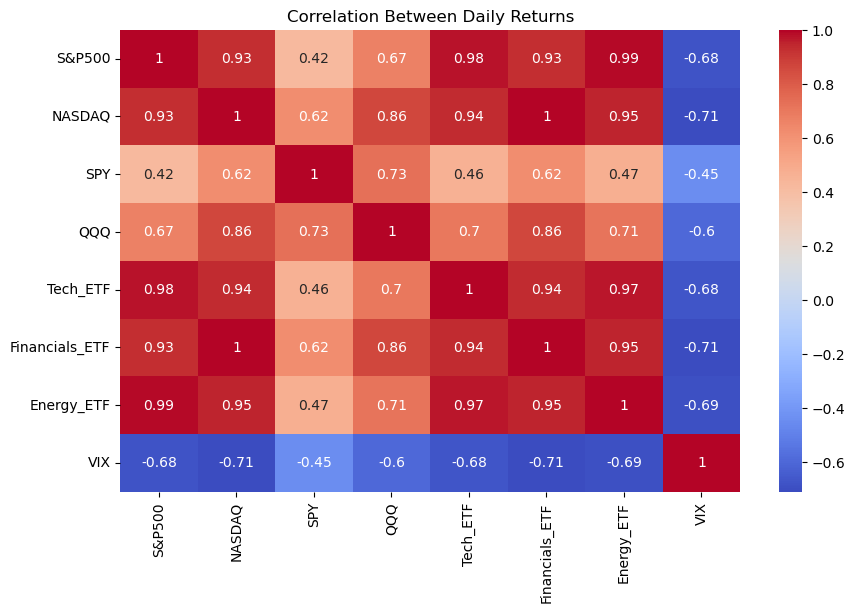

            S&P500       NASDAQ          SPY          QQQ     Tech_ETF  \
count  1257.000000  1257.000000  1257.000000  1257.000000  1257.000000   
mean      0.092866     0.066359     0.075493     0.057841     0.109137   
std       1.601086     1.322607     2.299918     1.670054     1.723943   
min     -11.978798   -10.942362   -20.141181   -13.709329   -13.813972   
25%      -0.675996    -0.497853    -1.025885    -0.665196    -0.737473   
50%       0.138377     0.086170     0.079146     0.080101     0.146343   
75%       0.933850     0.723639     1.211875     0.848082     1.023776   
max       8.470560     9.060314    16.037350    13.156606    11.731891   

       Financials_ETF   Energy_ETF          VIX  
count     1257.000000  1257.000000  1257.000000  
mean         0.060152     0.077212     0.249657  
std          1.343246     1.584673     8.041224  
min        -11.984055   -12.321331   -23.373525  
25%         -0.505157    -0.663954    -4.415221  
50%          0.090319     0.13290

In [4]:
##### Step 2: Get market data
##### =========================
tickers = [
    '^GSPC',    # S&P 500
    '^IXIC',    # NASDAQ
    'SPY',      # SPY (S&P 500 ETF)
    'QQQ',      # QQQ (NASDAQ ETF)
    'XLK',      # Tech Sector ETF
    'XLF',      # Financials ETF
    'XLE',      # Energy ETF
    '^VIX',     # Market Volatility (VIX)"
]

Symbol = ['S&P500', 'NASDAQ', 'SPY', 'QQQ', 'Tech_ETF', 'Financials_ETF', 'Energy_ETF', 'VIX']

# Define date range (e.g., past 5 years)
start_date = '2019-01-01'
end_date = '2023-12-31'

# Fetch data
data = yf.download(
    tickers=tickers,
    start=start_date,
    end=end_date,
    # Optional: Adjust granularity (default is daily)
    interval='1d',  # '1d', '1wk', '1mo'
    # Fetch adjusted close prices to account for splits/dividends
    auto_adjust=False
)

# Extract "Adj Close" for all tickers
adj_close = data['Adj Close'].dropna()
adj_close.columns = Symbol

# Calculate daily percentage returns
daily_returns = adj_close.pct_change() * 100  # Returns in percentage
daily_returns = daily_returns.dropna()  # Remove first row (NaN)
#print(daily_returns.head())

# Calculate cumulative returns (assuming reinvestment)
cumulative_returns = (1 + daily_returns / 100).cumprod() - 1


#print(adj_close.head())
daily_returns.to_csv('daily_returns.csv')
adj_close.to_csv('adjusted_close_prices.csv')

##### Step 3: Visualization
##### =====================

# ---------------------------------------------------------------------
# Plot Adj Close
# Normalize to starting value = 100
normalized = adj_close.div(adj_close.iloc[0]) * 100

plt.figure(figsize=(12, 6))
for column in normalized.columns:
    plt.plot(normalized.index, normalized[column], label=column)

plt.title('Normalized Adj_Close Price')
plt.xlabel('Date')
plt.ylabel('Normalized Price (Base 100)')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------------------
# Plot Cumulative Returns
plt.figure(figsize=(12, 6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------------------
# Plot Correlation Heatmap
correlation_matrix = daily_returns.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Daily Returns')
plt.show()

print(daily_returns.describe())

In [5]:
#Load preprocessed data
daily_clusters = pd.read_csv('sentiment score_test_data.csv')  # Assuming a CSV with a 'text' column
market_return = pd.read_csv('daily_returns.csv')  # Assuming a CSV with date and daily returns

##### Step 4: Merge news sentiment with market data
##### ===============================================
daily_clusters['date'] = pd.to_datetime(daily_clusters['date'])
market_return['Date'] = pd.to_datetime(market_return['Date'])

l=['Date']
for ticker in Symbol:
    l.append(ticker)
    
merged_data = pd.merge(
    daily_clusters,
    market_return[l],
    left_on="date",
    right_on="Date",
    how="inner"
).drop("Date", axis=1)

# Add market direction labels (e.g., ±0.5% threshold)
threshold = 0.5
for ticker in Symbol:
    return_col = f"{ticker}"
    direction_col = f"{ticker}_direction"
    
    merged_data[direction_col] = np.where(
        merged_data[return_col] > threshold, "Up",
        np.where(merged_data[return_col] < -threshold, "Down", "Neutral")
    ) 

# If some dates lack news data:
# Option 1: Forward-fill cluster labels (use previous day's cluster)
# merged_data['cluster'] = merged_data['cluster'].ffill()
# Option 2: Drop dates with missing news data
# merged_data = merged_data.dropna(subset=['cluster'])
merged_data["lagged_cluster"] = merged_data["cluster"].shift(1)
merged_data["lagged_sentiment"] = merged_data["sentiment_score"].shift(1)
merged_data.dropna(inplace=True)

merged_data.to_csv('clustered_news_market_data.csv', index=False)

lagged_cluster
0.0   -0.280412
1.0   -0.657604
2.0   -0.280412
Name: S&P500, dtype: float64
lagged_cluster
0.0    0.643293
1.0   -0.024940
2.0    0.643293
Name: NASDAQ, dtype: float64
lagged_cluster
0.0    3.764666
1.0    2.562551
2.0    3.764666
Name: SPY, dtype: float64
lagged_cluster
0.0    2.431676
1.0    1.168836
2.0    2.431676
Name: QQQ, dtype: float64
lagged_cluster
0.0   -0.537790
1.0   -0.902031
2.0   -0.537790
Name: Tech_ETF, dtype: float64
lagged_cluster
0.0    0.639622
1.0   -0.065413
2.0    0.639622
Name: Financials_ETF, dtype: float64
lagged_cluster
0.0    0.169606
1.0   -0.377892
2.0    0.169606
Name: Energy_ETF, dtype: float64
lagged_cluster
0.0   -3.554630
1.0    3.813396
2.0   -3.554630
Name: VIX, dtype: float64
S&P500_return ANOVA p-value: 0.9429
NASDAQ_return ANOVA p-value: 0.6062
SPY_return ANOVA p-value: 0.6816
QQQ_return ANOVA p-value: 0.8536
Tech_ETF_return ANOVA p-value: 0.9526
Financials_ETF_return ANOVA p-value: 0.6075
Energy_ETF_return ANOVA p-value: 0.8349

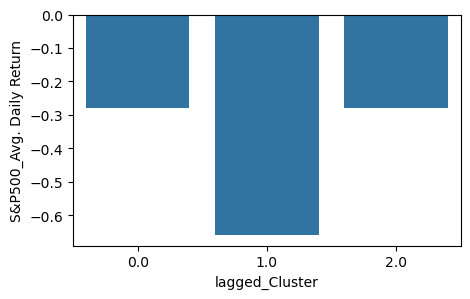

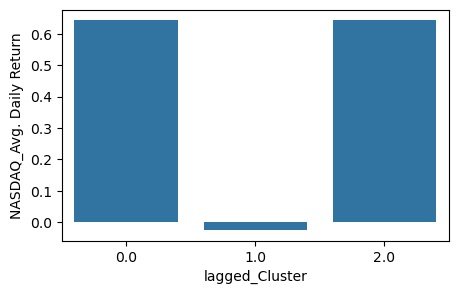

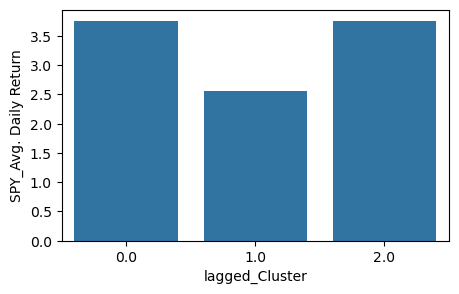

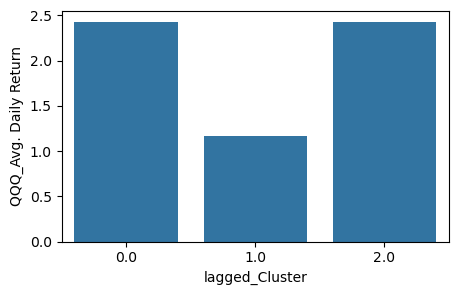

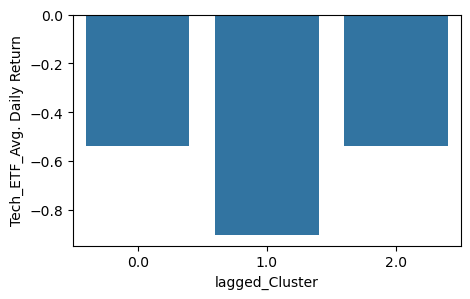

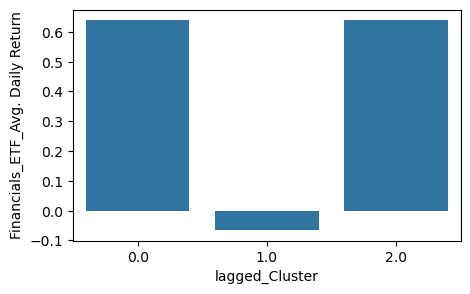

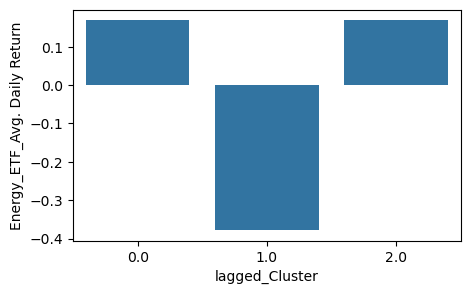

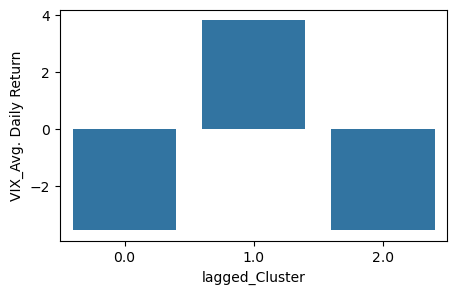

S&P500_direction 
Chi-square p-value: 0.9074
NASDAQ_direction 
Chi-square p-value: 0.4594
SPY_direction 
Chi-square p-value: 0.4594
QQQ_direction 
Chi-square p-value: 0.8168
Tech_ETF_direction 
Chi-square p-value: 0.9074
Financials_ETF_direction 
Chi-square p-value: 0.4594
Energy_ETF_direction 
Chi-square p-value: 0.9074
VIX_direction 
Chi-square p-value: 0.4594


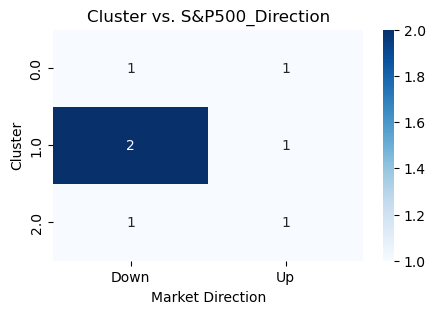

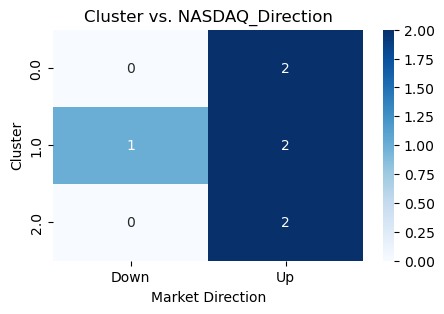

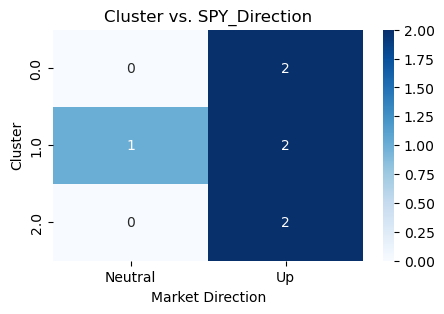

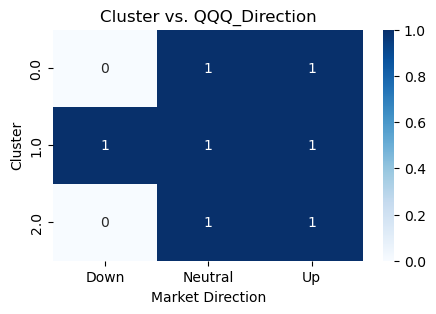

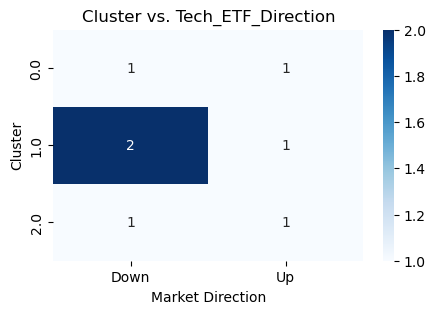

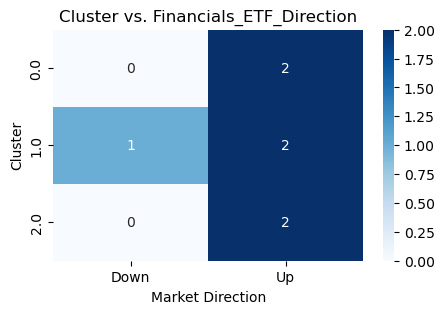

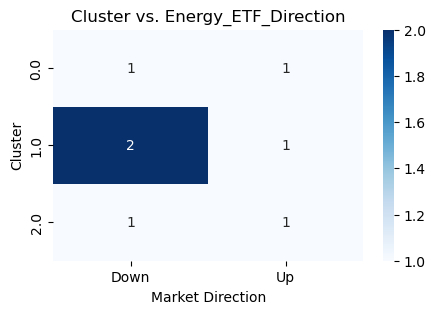

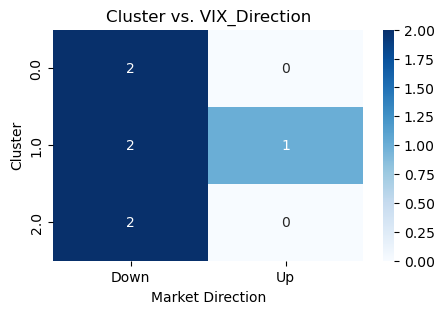

In [17]:
##### Step 5: Do some analysis
##### ========================

# Load preprocessed data with cluster labels and market returns
# Assume `df` has columns: ['date', 'cluster_label', 'daily_return', 'market_direction']
df = pd.read_csv('clustered_news_market_data.csv')

# ---------------------------------------------------------------------
# 1. Statistical Analysis: Cluster vs. Market Returns
# ---------------------------------------------------------------------
# ANOVA test to compare mean returns across clusters
clusters = df['cluster'].unique()
for ticker in Symbol:
    return_col = f"{ticker}"
    cluster_returns = merged_data.groupby('lagged_cluster')[return_col].mean()
    print(cluster_returns)
    
for ticker in Symbol:
    return_col = f"{ticker}"
    grouped_returns = [merged_data[merged_data["lagged_cluster"] == c][return_col] for c in clusters]
    f_stat, p_value = f_oneway(*grouped_returns)
    print(f"{ticker}_return ANOVA p-value: {p_value:.4f}")
    plt.figure(figsize=(5, 3))
    sns.barplot(x='lagged_cluster', y=return_col, data=df, errorbar=None)
    #plt.title(f"Cluster vs. {ticker}_Return")
    plt.xlabel("lagged_Cluster")
    plt.ylabel(f"{ticker}_Avg. Daily Return")
plt.show()

# ---------------------------------------------------------------------
# 2. Cluster vs. Market Direction (Categorical Analysis)
# ---------------------------------------------------------------------
# Create contingency table: Cluster vs. Market Direction (Up/Down/Neutral)
for ticker in Symbol:
    direction_col = f"{ticker}_direction"
    contingency_table = pd.crosstab(df['lagged_cluster'], df[direction_col])
    # Chi-square test for independence
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"{ticker}_direction \nChi-square p-value: {p:.4f}")
    # Heatmap: Cluster vs. Market Direction
    plt.figure(figsize=(5, 3))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Cluster vs. {ticker}_Direction")
    plt.xlabel("Market Direction")
    plt.ylabel("Cluster")
    
plt.show()



In [7]:
# ---------------------------------------------------------------------
# 3. Correlation Analysis
# ---------------------------------------------------------------------

cl=['lagged_cluster', 'lagged_sentiment']
for ticker in Symbol:
    cl.append(ticker)
    
correlation = df[cl].corr()
print("Correlation Matrix:")
print(correlation)


Correlation Matrix:
                  lagged_cluster  lagged_sentiment        S&P500  \
lagged_cluster      1.000000e+00          0.057022  3.825751e-17   
lagged_sentiment    5.702196e-02          1.000000 -5.285643e-01   
S&P500              3.825751e-17         -0.528564  1.000000e+00   
NASDAQ             -4.478322e-17         -0.207781  4.162007e-01   
SPY                -8.100928e-17         -0.388852  7.524073e-01   
QQQ                 0.000000e+00          0.299343 -5.450360e-01   
Tech_ETF            0.000000e+00         -0.528713  9.994072e-01   
Financials_ETF     -4.236607e-17         -0.220222  4.394588e-01   
Energy_ETF          0.000000e+00         -0.500435  9.543676e-01   
VIX                -2.599645e-18          0.313001 -6.122555e-01   

                        NASDAQ           SPY       QQQ  Tech_ETF  \
lagged_cluster   -4.478322e-17 -8.100928e-17  0.000000  0.000000   
lagged_sentiment -2.077807e-01 -3.888518e-01  0.299343 -0.528713   
S&P500            4.162007e

R² Score: 0.000
MSE: 1.896213
Coefficient (Sentiment → Return): -2.7023


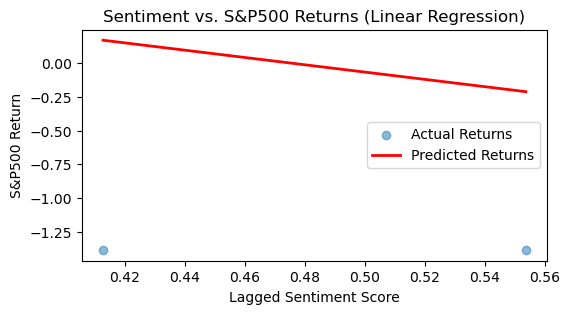

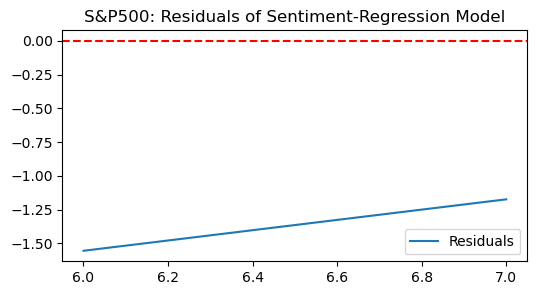

R² Score: 0.000
MSE: 0.108998
Coefficient (Sentiment → Return): -0.6372


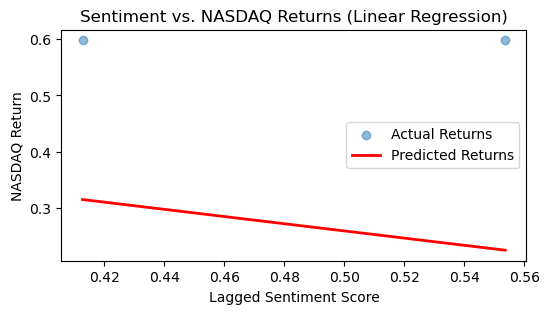

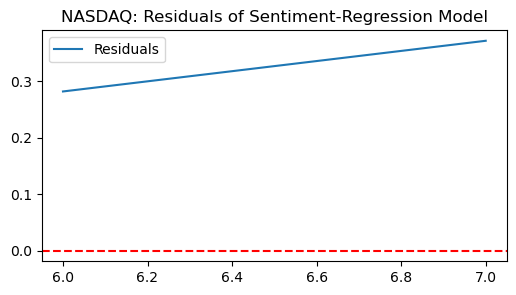

R² Score: 0.000
MSE: 0.132811
Coefficient (Sentiment → Return): -2.5181


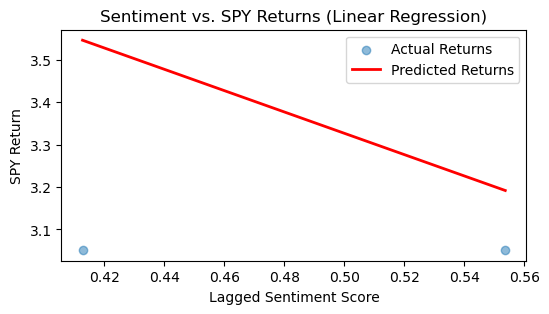

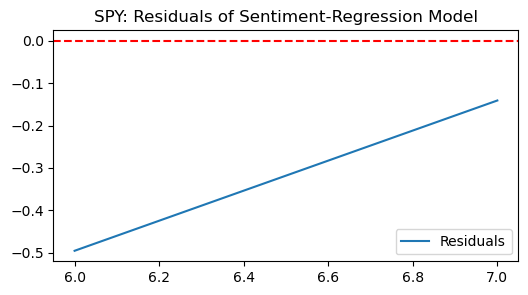

R² Score: 0.000
MSE: 12.934506
Coefficient (Sentiment → Return): 3.2904


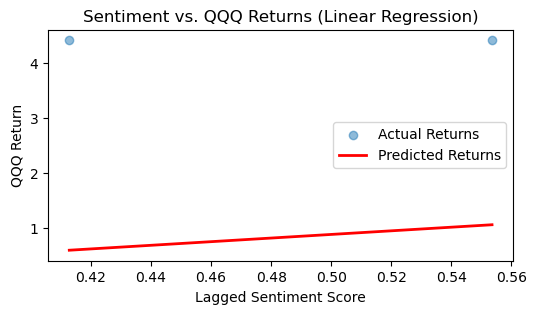

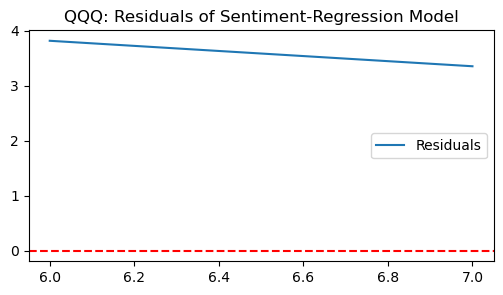

R² Score: 0.000
MSE: 2.257748
Coefficient (Sentiment → Return): -2.8696


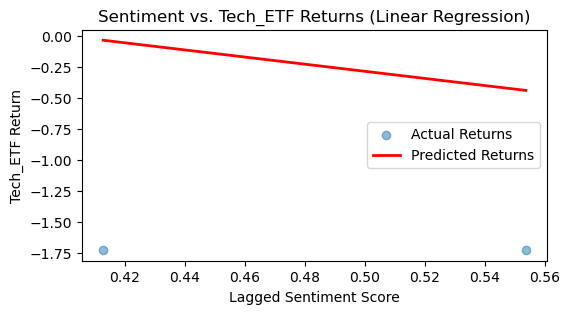

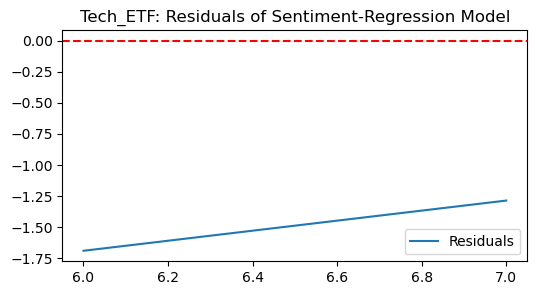

R² Score: 0.000
MSE: 0.102042
Coefficient (Sentiment → Return): -0.7172


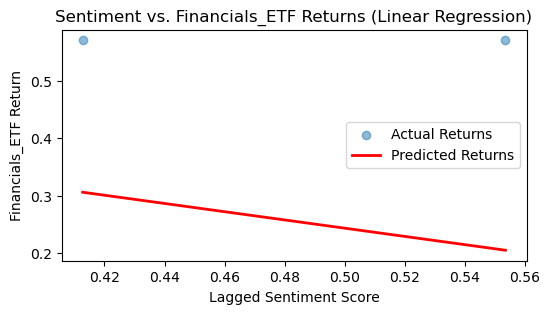

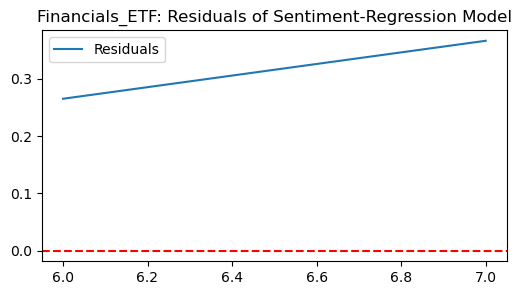

R² Score: 0.000
MSE: 0.657623
Coefficient (Sentiment → Return): -2.1331


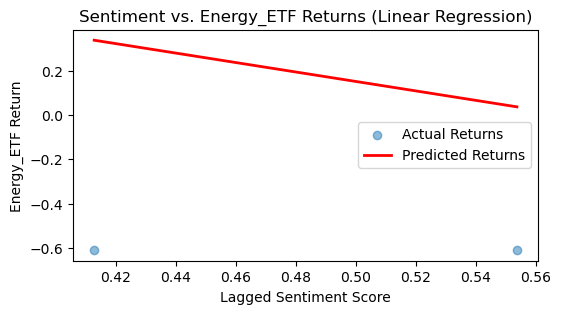

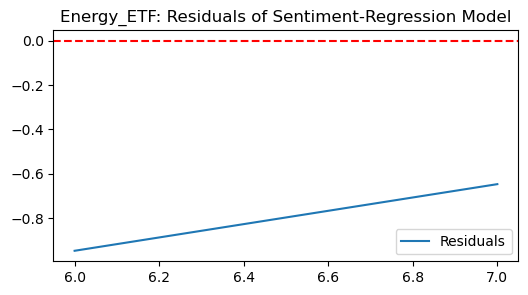

R² Score: 0.000
MSE: 1.206846
Coefficient (Sentiment → Return): 11.3411


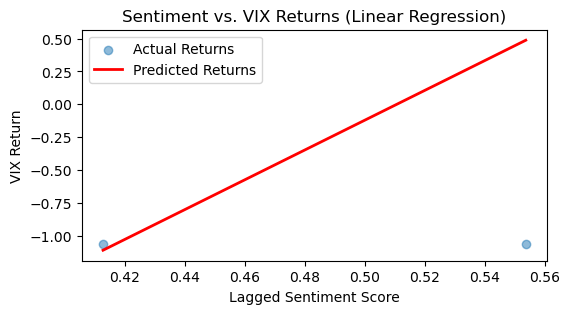

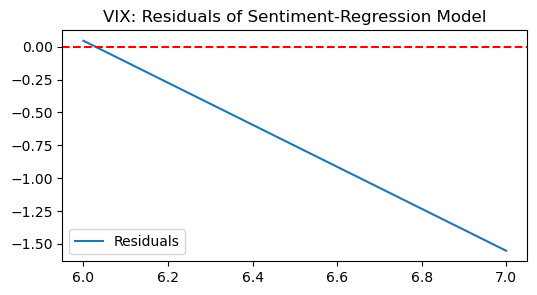

In [10]:
# --------------------------
# 4. Regression Analysis
# --------------------------
X = merged_data[['lagged_sentiment']]  # Predictor (lagged sentiment)
for ticker in Symbol:
    y = merged_data[f'{ticker}']              # Target (daily return)
    # Split data (time-series split)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    # Fit linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_test)
    print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")
    print(f"Coefficient (Sentiment → Return): {model.coef_[0]:.4f}")
    
    plt.figure(figsize=(6, 3))
    plt.scatter(X_test, y_test, alpha=0.5, label='Actual Returns')
    plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Returns')
    plt.xlabel("Lagged Sentiment Score")
    plt.ylabel(f"{ticker} Return")
    plt.title(f"Sentiment vs. {ticker} Returns (Linear Regression)")
    plt.legend()
    plt.show()
    
    # Residuals plot
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 3))
    plt.plot(residuals, label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"{ticker}: Residuals of Sentiment-Regression Model")
    plt.legend()
    plt.show()

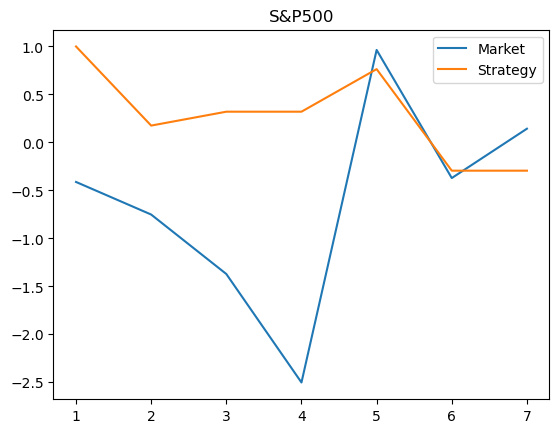

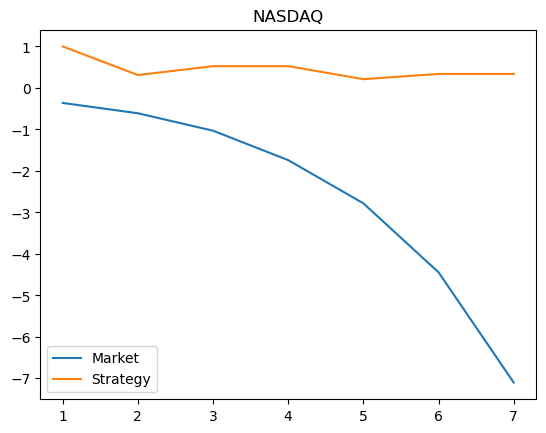

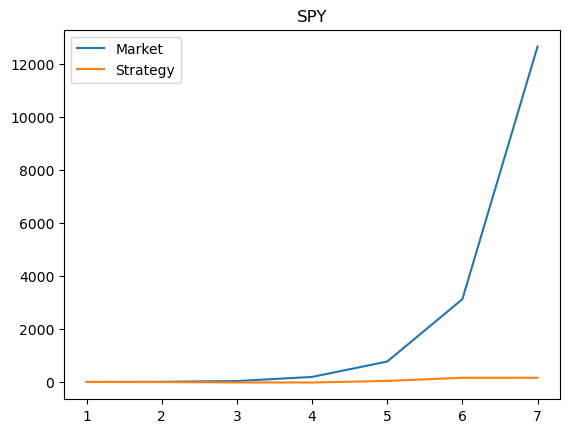

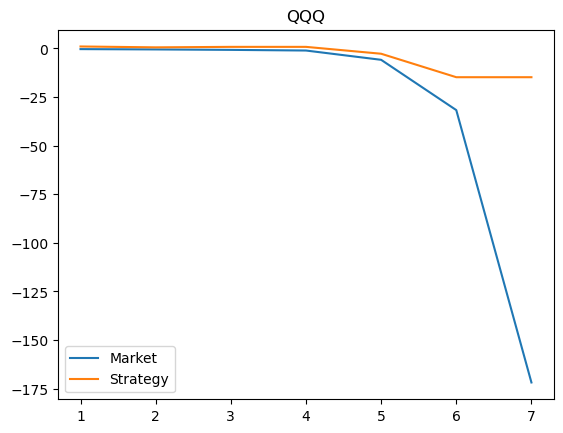

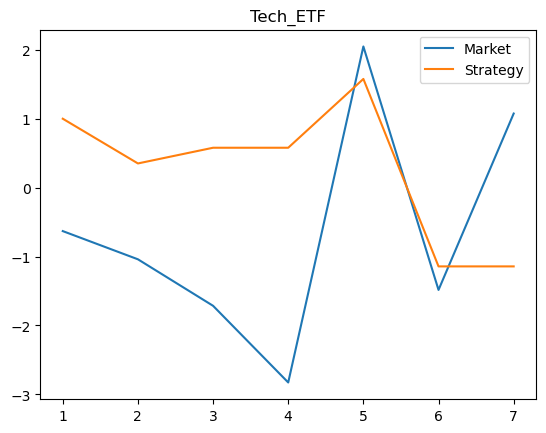

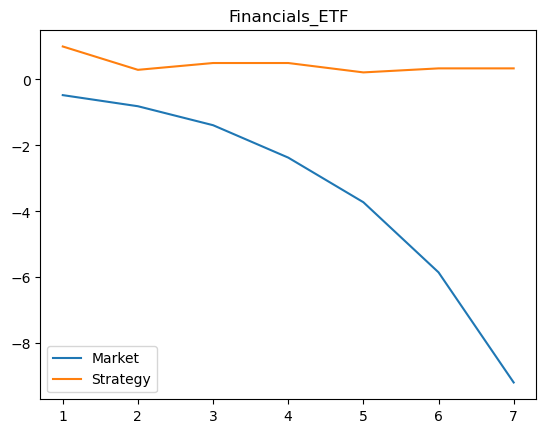

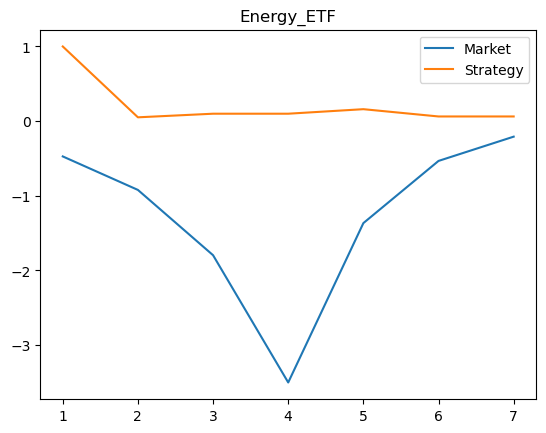

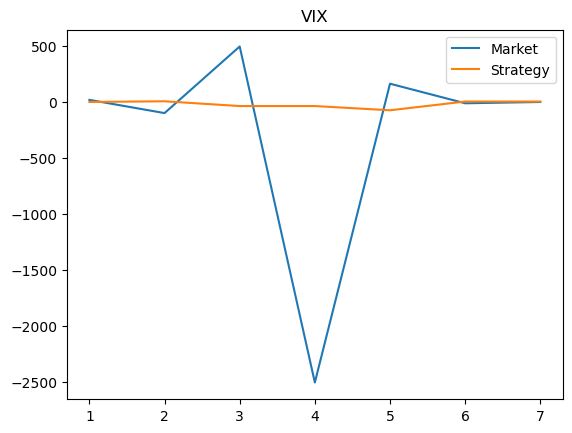

In [21]:
# 6. Trading Strategy Design

# Contrarian Strategy: Short when sentiment is extremely positive but returns are historically negative.

def generate_signals(row):
    if row['lagged_cluster'] == 0:  # Assume cluster 0 predicts positive returns
        return 1  # Buy
    elif row['lagged_cluster'] == 2:  # Assume cluster 2 predicts negative returns
        return -1  # Sell
    else:
        return 0  # Neutral

merged_data['signal'] = merged_data.apply(generate_signals, axis=1)

for ticker in Symbol:
    return_col = f"{ticker}"
    # Calculate strategy returns
    merged_data[f'{ticker} strategy_returns'] = merged_data['signal'] * merged_data[return_col]
    # Cumulative returns
    cumulative_market = (1 + merged_data[return_col]).cumprod()
    cumulative_strategy = (1 + merged_data[f'{ticker} strategy_returns']).cumprod()
    
    # Plot results
    plt.title(f'{ticker}')
    plt.plot(cumulative_market, label='Market')
    plt.plot(cumulative_strategy, label='Strategy')
    plt.legend()
    plt.show()